A fan is a tuple `R = (r_0, ..., r_{m-1})` of rays (given as sage.vector) which support your fan, and a tuple of tuples `CC = (C_0, ..., C_{p-1})` where `C_i` is a tuple of indexes between `0` and `m-1`.
Each `C_i` represent a maximal cone of your fan.

3 objects are important for you fan:
* Deformation cone (i.e. what you want to compute): each vector `h` in this cone encodes a polytope `P_h`. If `h` is in the interior of the cone, then the normal fan of `P_h` is your fan.
* Adjacency graph: graph whose vertices are `C_0, ..., C_{p-1}`, and there is an edge between `C_i`and `C_j` if and only if $C_i\cap C_j$ is a cone of co-dimension 1.
* Triangulation: a triangulation of your fan is a tuple `S = (s_0, ..., s_{l-1})` of rays, which contains `R`, and a tuple of tuples of tuples `TT = (T_0, ..., T_{p-1})` such that `T_i = (t_0, ..., t_{q-1})` is a tuple of tuples where `t_i` is a tuple of `d+1` indices between `0`and `l-1`, representing a simplcial cone, and `T_i` represent a triangulation of the cone `C_i`.

In [1]:
# There will be problems if the fan has non-zero lineality...

from time import localtime

def time_show():
    return str(localtime()[3]) + 'h' + str(localtime()[4])

def adjacency_graph(R, CC, verbose = False):
    """Return the adjacency graph of the fan
    The edges are `(i, j, label)` meaning there is an edge between
    the cones `CC[i]` and `CC[j]`, and `label = CC[i].intersection(CC[j])`"""
    G = Graph()
    lCC = len(CC)
    d = len(R[0])
    for i in range(lCC):
        for j in range(i+1, lCC):
            Ci, Cj = CC[i], CC[j]
            I = set(Ci).intersection(set(Cj))
            if len(I) >= d-1:
                #C = Polyhedron(rays = [R[k] for k in I]) # maybe enough to test len(I) >= d-1 ?
                #if Polyhedron(rays = [R[k] for k in I]).dimension() == d-1:
                M = Matrix([R[k] for k in I])
                if M.rank() >= d-1:
                    G.add_edge((i, j, Set(I)))
    if verbose:
        print("Sanity check:", sanity_check(G, d - len(lines_in_fan(R, CC))))
    return G

def lines_in_fan(R, CC):
    """Return the vectors `v` such that `v` and `-v` are in all cones
    (enough to test if they are in 1 cone)"""
    return tuple([v for v in R if any(v in C and -v in C for C in CC)])

def sanity_check(G, d):
    """Check if `G` may be the graph of a `d`-polytope (i.e. `d`-connectedness + planar if `d = 3`)"""
    c = G.vertex_connectivity()
    if d == 3:
        return c == 3 and  G.is_planar()
    else:
        return c == d

def relation(ri, rj, rI):
    """Return alpha such that sum( alpha[k] * r[k] ) = 0
    (written in a weird way & with integers)"""
    #print(ri)
    #print(rj)
    #print(rI)
    M = Matrix([rj] + rI).T
    alpha = M.solve_right(ri)
    m = lcm(x.denominator() for x in alpha)
    #print(m, alpha)
    return (m, -alpha[0]*m, [-alpha[i]*m for i in range(1, len(alpha))])

def wall_crossing_inequalities_for_adjacent_cones(R, CC, i, j, I = None, quantity="all"):
    """Return all or one (depending on `quantity`) wall crossing inequalities
    between two cones CC[i] and CC[j], supposed to be adjacent"""
    lR = len(R)
    Ci, Cj = CC[i], CC[j]
    if I == None:
        I = set(Ci).intersection(set(Cj))
    I = tuple(I)
    lI = len(I)
    Ci_pure = set(Ci).difference(I)
    Cj_pure = set(Cj).difference(I)
    REL = set()
    if quantity == "all":
        for i in Ci_pure:
            for j in Cj_pure:
                Alpha = relation(R[i], R[j], [R[k] for k in I])
                rel = [0 for _ in range(lR)]
                rel[i] = Alpha[0]
                rel[j] = Alpha[1]
                for k in range(lI):
                    rel[I[k]] = Alpha[2][k]
                REL.add(tuple(rel))
    else:
        i = Ci_pure.pop()
        j = Cj_pure.pop()
        Alpha = relation(R[i], R[j], [R[k] for k in I])
        rel = [0 for _ in range(lR)]
        rel[i] = Alpha[0]
        rel[j] = Alpha[1]
        for k in range(lI):
            rel[I[k]] = Alpha[2][k]
        REL.add(tuple(rel))
    return REL

def intrinsic_equalities_for_cone(R, CC, i):
    """Return all the (wall crossing) equalities induced by the cone CC[i]
    If CC[i] is simplicial, then return `set()`"""
    REL = set()
    d, lR = len(R[0]), len(R)
    Ci = CC[i]
    if len(Ci) == d:
        return set()
    #print(Ci, I)
    for X in Subsets(Ci, d):
        M = Matrix([R[k] for k in X]).T
        if M.det() != 0:
            break
    X = list(X)
    M = (Matrix([R[k] for k in X]).T).inverse()
    if M.det() == 0:
        print(i)
        print(M)
        print("gros problème !")
    #print(M)
    for k in Ci:
        if not k in X:
            v = R[k]
            alpha = M * v
            rel = [0 for _ in range(lR)]
            m = lcm(x.denominator() for x in alpha)
            #print(alpha, m)
            rel[k] = m
            for j in range(len(X)):
                rel[X[j]] = -alpha[j] * m
            REL.add(tuple(rel))
    return REL

def wall_crossing_inequalities_and_equalities(R, CC, verbose = False, super_verbose = False):
    """Return all the wall crossing inequalities and the equalities of the fan
    i.e. the defining (in)equalities for the deformation cone"""
    if super_verbose:
        print(time_show(), "start constructing adjacency graph")
    G = adjacency_graph(R, CC)
    
    if super_verbose:
        print(time_show(), "adjacency graph done, start equalities")
    
    EQ = set()
    lCC = len(CC)
    for i in range(lCC):
        if super_verbose:
            if i in {floor(k * lCC / 10) for k in range(1, 11)}:
                print(" ", time_show(), "processing cone", i+1, "out of", lCC)
        EQ.update(intrinsic_equalities_for_cone(R, CC, i))
    
    if super_verbose:
        print(time_show(), "equalities done, start inequalities")
    
    IQ = set()
    lE = len(G.edges())
    e = 1
    for i, j, I in G.edges():
        if super_verbose:
            if e in {floor(k * lE / 10) for k in range(1, 11)}:
                print(" ", time_show(), "processing adjacency", e, "out of", lE)
            e += 1
        IQ.update(wall_crossing_inequalities_for_adjacent_cones(R, CC, i, j, I, "one"))
    
    if super_verbose:
        print(time_show(), "inequalities done")
        print(len(EQ), "equalities, and", len(IQ), "inequalties")
    
    if verbose:
        print("Equalities:")
        for eq in EQ:
            print(eq)
        print()
        print("Inequalities:")
        for iq in IQ:
            print(iq)
    
    return EQ, IQ

def deformation_cone(R, CC, verbose = False, super_verbose = False):
    """Return the deformation cone of the fan"""
    EQ, IQ = wall_crossing_inequalities_and_equalities(R, CC, verbose = verbose, super_verbose = super_verbose)
    return Polyhedron(eqns=[[0] + list(eq) for eq in EQ], ieqs=[[0] + list(iq) for iq in IQ])

def Ph(R, h):
    """For a collection of rays `R` and a height vector `h`, return the associated polytope"""
    return Polyhedron(ieqs = [[h[i]] + list(-R[i]) for i in range(len(R))])

def try_to_find_a_realisation(R, CC, verbose = False, super_verbose = False):
    """Will try to find a polytopal realization of your fan and return one if found"""
    EQ, IQ = wall_crossing_inequalities_and_equalities(R, CC, verbose = verbose, super_verbose = super_verbose)
    
    if super_verbose:
        print(time_show(), "initializing linear program")
    LP = MixedIntegerLinearProgram()
    x = LP.new_variable(integer=True)
    LP.set_objective(None)
    eps = 1 # Mouais...........................
    for iq in IQ:
        LP.add_constraint( sum(iq[i]*x[i] for i in range(len(iq))) >= eps )
    for eq in EQ:
        LP.add_constraint( sum(eq[i]*x[i] for i in range(len(eq))) == 0 )
    if super_verbose:
        print(time_show(), "start solving")
    try:
        LP.solve()
    except MIPSolverException:
        print("Your fan is not polytopal (sad).")
        return None
    
    sol = LP.get_values(x)
    h = vector([QQ(sol[k]) for k in range(len(iq))])
    P = Ph(R, h)
    if super_verbose:
        print(time_show(), "finished!")
    if P.n_vertices() == len(CC) and P.n_facets() == len(R): # check that no strict deformation has occured
        return h, P
    print("Your fan is not polytopal (sad).")
    return None

In [2]:
def normal_fan_of_polytope(P):
    """Return the normal fan of a polytope in format `(R, CC)`
    (works even if the polytope is embedded in higher dimension)"""
    VFG = P.vertex_facet_graph()
    S = list(VFG.sinks())
    CC = [[S.index(f) for f in VFG.neighbors(v)] for v in VFG.sources()]
    R = [-iq.vector()[1:] for iq in S]
    
    for eq in P.equations():
        R.append(eq.vector()[1:])
        R.append(-eq.vector()[1:])
        k = len(R)
        for C in CC:
            C.append(k-2)
            C.append(k-1)
    
    return tuple(R), tuple([tuple(C) for C in CC])

def normalize(u, style="rational"):
    if style == "rational":
        v = vector(u)
        v *= lcm([x.denominator() for x in v])
        v /= gcd([x for x in v])
        return v
    return vector(u) / u.norm()

def are_equivalent_fans(RCC1, RCC2, verbose = False):
    """Compare if two fans are the same (but written in different ways)
    DO NOT WORK if you have equalities (i.e. non essential fan)"""
    R1, CC1 = RCC1
    R2, CC2 = RCC2
    if len(R1) != len(R2) or len(CC1) != len(CC2):
        if verbose:
            print("not same lengths")
        return False
    
    sorter = []
    lR = len(R1)
    for k in range(lR):
        r1 = R1[k]
        b = False
        for j in range(lR):
            r2 = R2[j]
            if normalize(r2, "rational") == normalize(r1, "rational"):
                sorter.append(j)
                b = True
                break
        if not b:
            if verbose:
                print("Ray in first fan but not in second fan", r1)
            return False
    if len(set(sorter)) != lR:
        if verbose:
            print("Some rays are repeated")
        return False
    s2 = [set(C) for C in CC2]
    for C in CC1:
        if not set(sorter[k] for k in C) in s2:
            if verbose:
                print(C, tuple([sorter[k] for k in C]))
            return False
    return True

In [79]:
# mise en forme

CC = [[(-1/4, 1/2, 1/4), (-1/4, -1/2, -3/4), (-1/4, -1/2, 1/4)], [(-1/4, 1/2, 1/4), (-1/4, -1/2, -3/4), (1/4, 1/2, -1/4)], [(-1/4, 1/2, 1/4), (-1/4, -1/2, 5/4), (-1/4, -1/2, 1/4)], [(-1/4, 1/2, 1/4), (1/4, 1/2, 7/4), (1/4, 1/2, 3/4)], [(-1/4, 1/2, 1/4), (1/2, 1, 1/2), (1/4, 1/2, 3/4)], [(-1/4, 1/2, 1/4), (-1/4, -1/2, 5/4), (0, 0, 1)], [(-1/4, 1/2, 1/4), (1/4, 1/2, 7/4), (0, 0, 1)], [(-1/4, 1/2, 1/4), (1/2, 1, 1/2), (1/4, 1/2, -1/4)], [(-1/4, -1/2, -3/4), (-1/4, -3/2, 1/4), (0, -1, 0)], [(-1/4, -1/2, -3/4), (1/4, -3/2, -1/4), (0, -1, 0)], [(-1/4, -1/2, -3/4), (1/2, 0, -1/2), (1/4, 1/2, -1/4)], [(-1/4, -1/2, -3/4), (-1/4, -3/2, 1/4), (-1/4, -1/2, 1/4)], [(-1/4, -1/2, -3/4), (1/4, -3/2, -1/4), (1/4, -1/2, -1/4)], [(-1/4, -1/2, -3/4), (1/2, 0, -1/2), (1/4, -1/2, -1/4)], [(-1/4, -3/2, 5/4), (-1/4, -3/2, 1/4), (0, -1, 0)], [(1/4, -3/2, 7/4), (1/4, -3/2, 3/4), (0, -1, 0)], [(1/2, -2, 1/2), (1/4, -3/2, 3/4), (0, -1, 0)], [(1/2, 0, 5/2), (1/2, 0, 3/2), (1/4, 1/2, 3/4)], [(3/4, -1/2, 5/4), (1/2, 0, 3/2), (1/4, 1/2, 3/4)], [(3/4, 1/2, 1/4), (1/2, 1, 1/2), (1/4, 1/2, 3/4)], [(-1/4, -3/2, 5/4), (0, -1, 1), (0, -1, 0)], [(1/4, -3/2, 7/4), (0, -1, 1), (0, -1, 0)], [(1/2, -2, 1/2), (1/4, -3/2, -1/4), (0, -1, 0)], [(1/2, 0, 5/2), (1/4, 1/2, 7/4), (1/4, 1/2, 3/4)], [(3/4, -1/2, 5/4), (1/2, 0, 1/2), (1/4, 1/2, 3/4)], [(3/4, 1/2, 1/4), (1/2, 0, 1/2), (1/4, 1/2, 3/4)], [(-1/4, -3/2, 5/4), (-1/4, -1/2, 5/4), (-1/4, -3/2, 1/4), (-1/4, -1/2, 1/4)], [(1/4, -3/2, 7/4), (1/4, -1/2, 7/4), (1/4, -3/2, 3/4), (1/4, -1/2, 3/4)], [(1/2, -2, 1/2), (1/2, -1, 1/2), (1/4, -3/2, 3/4), (1/4, -1/2, 3/4)], [(1/2, 0, 5/2), (1/4, -1/2, 7/4), (1/2, 0, 3/2), (1/4, -1/2, 3/4)], [(3/4, -1/2, 5/4), (1/2, -1, 1/2), (1/2, 0, 3/2), (1/4, -1/2, 3/4)], [(3/4, 1/2, 1/4), (1/2, 0, -1/2), (1/2, 1, 1/2), (1/4, 1/2, -1/4)], [(-1/4, -3/2, 5/4), (0, -1, 1), (0, 0, 1)], [(1/4, -3/2, 7/4), (0, -1, 1), (0, 0, 1)], [(1/2, -2, 1/2), (1/4, -3/2, -1/4), (1/4, -1/2, -1/4)], [(1/2, 0, 5/2), (1/4, 1/2, 7/4), (0, 0, 1)], [(3/4, -1/2, 5/4), (1/2, 0, 1/2), (1/4, -1/2, -1/4)], [(3/4, 1/2, 1/4), (1/2, 0, 1/2), (1/4, -1/2, -1/4)], [(-1/4, -3/2, 5/4), (-1/4, -1/2, 5/4), (0, 0, 1)], [(1/4, -3/2, 7/4), (1/4, -1/2, 7/4), (0, 0, 1)], [(1/2, -2, 1/2), (1/2, -1, 1/2), (1/4, -1/2, -1/4)], [(1/2, 0, 5/2), (1/4, -1/2, 7/4), (0, 0, 1)], [(3/4, -1/2, 5/4), (1/2, -1, 1/2), (1/4, -1/2, -1/4)], [(3/4, 1/2, 1/4), (1/2, 0, -1/2), (1/4, -1/2, -1/4)]]

R = set()
for X in CC:
    R.update(set(X))
m = lcm(x.denominator() for v in R for x in v)
R = tuple([vector(v)*m for v in R])
print(len(R))
print(R)

print()

CC = tuple([tuple([R.index(vector(v)*m) for v in C]) for C in CC])
print(len(CC))

d = len(R[0])

try_to_find_a_realisation(R, CC)

27
((1, -6, -1), (2, 4, 2), (1, 2, 3), (0, 0, 4), (1, -6, 7), (0, -4, 4), (-1, -6, 5), (3, 2, 1), (0, -4, 0), (-1, -2, 5), (2, 0, 6), (-1, -2, -3), (1, -2, 3), (2, -8, 2), (2, -4, 2), (-1, 2, 1), (1, 2, -1), (2, 0, 10), (-1, -6, 1), (2, 0, -2), (1, 2, 7), (1, -6, 3), (1, -2, 7), (-1, -2, 1), (1, -2, -1), (2, 0, 2), (3, -2, 5))

44


((0, 11, 3, 7, 4, 8, 21, 7, 2, 21, -1, 12, -1, -6, -6, 17, 11, 4, 16, 7, 9, -1, 4, 16, -1, 0, -6),
 A 3-dimensional polyhedron in QQ^3 defined as the convex hull of 44 vertices)

In [1]:
P = Polyhedron(vertices=[[1, 0, 0], [0, 1, 0], [0, 0, 1]])
Q = Polyhedron(vertices=[[1, 1, 0], [0, 1, 1], [1, 0, 1]])

PP = Polyhedron(vertices=[[3, 2, 2], [2, 3, 2], [2, 2, 3]], rays=[[-1, 0, 0], [0, -1, 0], [0, 0, -1]])
QQ = Polyhedron(vertices=[[1, 1, 0], [0, 1, 1], [1, 0, 1]], rays=[[1, 0, 0], [0, 1, 0], [0, 0, 1]])
R = PP.intersection(QQ)
print(R)
R.show()
print(R.f_vector())
R.is_combinatorially_isomorphic(polytopes.cuboctahedron())

Rays, CC = normal_fan_of_polytope(R)

for i in range(len(Rays)):
    print(i, Rays[i])
print()
for C in CC:
    print([Rays[i] for i in C])
    
DC = deformation_cone(Rays, CC)
print(DC)
for h in DC.rays():
    Ph(Rays, h).show()

A 3-dimensional polyhedron in QQ^3 defined as the convex hull of 18 vertices


Graphics3d Object

(1, 18, 30, 14, 1)


NameError: name 'normal_fan_of_polytope' is not defined

Sanity check: True


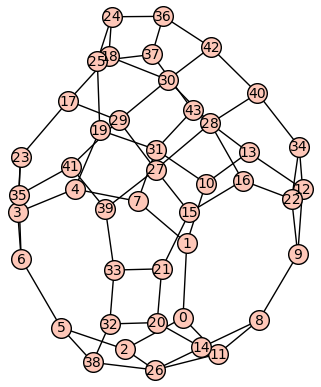

planar: True
connectivity: 3


In [32]:
G = adjacency_graph(R, CC, verbose=True)
G.show()
print("planar:", G.is_planar())
print("connectivity:", G.vertex_connectivity())

In [33]:
EQ, IQ = wall_crossing_inequalities_and_equalities(R, CC, verbose = True)

Equalities:
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0)
(0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0)

Inequalities:
(0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -3, 0, 0, 0, 0)
(0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)
(-1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

In [34]:
DC = deformation_cone(R, CC)
DC

A 21-dimensional polyhedron in QQ^27 defined as the convex hull of 1 vertex, 281 rays, 3 lines (use the .plot() method to plot)

In [36]:
h, P = try_to_find_a_realisation(R, CC)
P.show()
print(h)
R1, CC1 = normal_fan_of_polytope(P)
print("Is the result correct:", are_equivalent_fans((R, CC), (R1, CC1), verbose=True))

Graphics3d Object

(0, 11, 3, 7, 4, 8, 21, 7, 2, 21, -1, 12, -1, -6, -6, 17, 11, 4, 16, 7, 9, -1, 4, 16, -1, 0, -6)
Is the result correct: True


In [38]:
R = [(-2/5, 1/5, 4/5, 2/5),
 (-1/5, 3/5, 2/5, 1/5),
 (-1/5, -2/5, 2/5, 1/5),
 (-1/5, -2/5, -3/5, -4/5),
 (-1/5, -7/5, -13/5, 6/5),
 (1/5, -8/5, -12/5, 9/5),
 (2/5, -11/5, -14/5, 3/5),
 (2/5, -1/5, -9/5, 13/5),
 (3/5, -4/5, -11/5, 7/5),
 (3/5, 1/5, -11/5, 2/5),
 (3/5, 1/5, -1/5, 17/5),
 (4/5, -2/5, -3/5, 11/5),
 (4/5, 3/5, -3/5, 6/5),
 (4/5, 3/5, 2/5, 1/5),
 (-1/5, -7/5, -8/5, 6/5),
 (1/5, -8/5, -7/5, 9/5),
 (2/5, -11/5, -9/5, 3/5),
 (2/5, -1/5, -4/5, 13/5),
 (3/5, -4/5, -6/5, 7/5),
 (3/5, 1/5, -6/5, 2/5),
 (-1/5, -2/5, -8/5, 6/5),
 (1/5, -3/5, -7/5, 9/5),
 (2/5, -6/5, -9/5, 3/5),
 (0, -1, -2, 1),
 (-1/5, -7/5, -13/5, 1/5),
 (1/5, -8/5, -12/5, -1/5),
 (1/5, -8/5, -12/5, 4/5),
 (2/5, -1/5, -9/5, -2/5),
 (1/5, 2/5, -7/5, 9/5),
 (2/5, -1/5, -9/5, 3/5),
 (2/5, -1/5, -9/5, 8/5),
 (2/5, 4/5, -9/5, 3/5),
 (3/5, 1/5, -1/5, -3/5),
 (2/5, -1/5, 1/5, 13/5),
 (3/5, -4/5, -1/5, 7/5),
 (3/5, 1/5, -1/5, 2/5),
 (2/5, 4/5, 1/5, 13/5),
 (3/5, 1/5, -1/5, 7/5),
 (3/5, 1/5, -1/5, 12/5),
 (3/5, 6/5, -1/5, 7/5),
 (3/5, 1/5, 4/5, 2/5),
 (3/5, 6/5, 4/5, 2/5),
 (-1/5, -2/5, -3/5, 6/5),
 (1/5, -3/5, -2/5, 9/5),
 (2/5, -6/5, -4/5, 3/5),
 (0, -1, -1, 1),
 (-1/5, -7/5, -8/5, 1/5),
 (1/5, -8/5, -7/5, -1/5),
 (1/5, -8/5, -7/5, 4/5),
 (2/5, -1/5, -4/5, -2/5),
 (1/5, 2/5, -2/5, 9/5),
 (2/5, -1/5, -4/5, 3/5),
 (2/5, -1/5, -4/5, 8/5),
 (2/5, 4/5, -4/5, 3/5),
 (0, 0, -1, 1),
 (-1/5, -2/5, -8/5, 1/5),
 (1/5, -3/5, -7/5, -1/5),
 (1/5, -3/5, -7/5, 4/5),
 (0, -1, -2, 0),
 (1/5, 2/5, -7/5, -1/5),
 (1/5, 2/5, -7/5, 4/5),
 (2/5, -1/5, 1/5, -2/5),
 (2/5, 4/5, 1/5, -2/5),
 (1/5, 2/5, 3/5, 9/5),
 (2/5, -1/5, 1/5, 3/5),
 (2/5, -1/5, 1/5, 8/5),
 (2/5, 4/5, 1/5, 3/5),
 (2/5, 4/5, 1/5, 8/5),
 (2/5, 4/5, 6/5, 3/5),
 (0, 0, 0, 1),
 (-1/5, -2/5, -3/5, 1/5),
 (1/5, -3/5, -2/5, -1/5),
 (1/5, -3/5, -2/5, 4/5),
 (0, -1, -1, 0),
 (1/5, 2/5, -2/5, -1/5),
 (1/5, 2/5, -2/5, 4/5),
 (0, 0, -1, 0),
 (1/5, 2/5, 3/5, -1/5),
 (1/5, 2/5, 3/5, 4/5)]

CC = [[0, 1, 3, 70],
 [0, 2, 3, 70],
 [0, 1, 3, 77],
 [0, 2, 3, 77],
 [0, 1, 42, 70],
 [0, 2, 42, 70],
 [0, 1, 63, 78],
 [0, 2, 63, 78],
 [0, 1, 68, 78],
 [0, 2, 68, 78],
 [0, 1, 42, 69],
 [0, 2, 42, 69],
 [0, 1, 63, 69],
 [0, 2, 63, 69],
 [0, 1, 68, 77],
 [0, 2, 68, 77],
 [1, 3, 55, 76],
 [2, 3, 46, 73],
 [1, 3, 59, 76],
 [2, 3, 47, 73],
 [1, 3, 62, 77],
 [2, 3, 61, 77],
 [1, 3, 55, 70],
 [2, 3, 46, 70],
 [1, 3, 59, 74],
 [2, 3, 47, 71],
 [1, 3, 62, 74],
 [2, 3, 61, 71],
 [1, 20, 55, 76],
 [2, 14, 46, 73],
 [1, 28, 60, 76],
 [2, 15, 48, 73],
 [1, 31, 60, 76],
 [2, 16, 48, 73],
 [1, 36, 67, 78],
 [2, 33, 65, 78],
 [1, 39, 67, 78],
 [2, 34, 65, 78],
 [1, 41, 68, 78],
 [2, 40, 68, 78],
 [1, 20, 54, 76],
 [2, 14, 45, 73],
 [1, 28, 54, 76],
 [2, 15, 45, 73],
 [1, 31, 59, 76],
 [2, 16, 47, 73],
 [1, 36, 63, 78],
 [2, 33, 63, 78],
 [1, 39, 66, 78],
 [2, 34, 64, 78],
 [1, 41, 66, 78],
 [2, 40, 64, 78],
 [1, 20, 42, 55, 70],
 [2, 14, 42, 46, 70],
 [1, 28, 50, 60, 75],
 [2, 15, 43, 48, 72],
 [1, 31, 53, 60, 75],
 [2, 16, 44, 48, 72],
 [1, 36, 50, 67, 75],
 [2, 33, 43, 65, 72],
 [1, 39, 53, 67, 75],
 [2, 34, 44, 65, 72],
 [1, 41, 62, 68, 77],
 [2, 40, 61, 68, 77],
 [1, 20, 54, 69],
 [2, 14, 45, 69],
 [1, 28, 54, 69],
 [2, 15, 45, 69],
 [1, 31, 59, 74],
 [2, 16, 47, 71],
 [1, 36, 63, 69],
 [2, 33, 63, 69],
 [1, 39, 66, 74],
 [2, 34, 64, 71],
 [1, 41, 66, 74],
 [2, 40, 64, 71],
 [1, 20, 42, 69],
 [2, 14, 42, 69],
 [1, 28, 50, 69],
 [2, 15, 43, 69],
 [1, 31, 53, 74],
 [2, 16, 44, 71],
 [1, 36, 50, 69],
 [2, 33, 43, 69],
 [1, 39, 53, 74],
 [2, 34, 44, 71],
 [1, 41, 62, 74],
 [2, 40, 61, 71],
 [3, 24, 58, 76],
 [3, 25, 58, 76],
 [3, 27, 59, 76],
 [3, 32, 62, 77],
 [3, 24, 55, 76],
 [3, 25, 56, 76],
 [3, 27, 56, 76],
 [3, 32, 61, 77],
 [3, 24, 46, 58, 73],
 [3, 25, 47, 58, 73],
 [3, 27, 49, 59, 74],
 [3, 32, 49, 62, 74],
 [3, 24, 55, 70],
 [3, 25, 56, 71],
 [3, 27, 56, 71],
 [3, 32, 61, 71],
 [3, 24, 46, 70],
 [3, 25, 47, 71],
 [3, 27, 49, 71],
 [3, 32, 49, 71],
 [4, 24, 58, 76],
 [5, 26, 58, 76],
 [6, 26, 58, 76],
 [7, 30, 60, 76],
 [8, 30, 60, 76],
 [9, 31, 60, 76],
 [10, 38, 67, 78],
 [11, 38, 67, 78],
 [12, 39, 67, 78],
 [13, 41, 68, 78],
 [4, 23, 58, 76],
 [5, 23, 58, 76],
 [6, 25, 58, 76],
 [7, 28, 60, 76],
 [8, 29, 60, 76],
 [9, 29, 60, 76],
 [10, 36, 67, 78],
 [11, 37, 67, 78],
 [12, 37, 67, 78],
 [13, 40, 68, 78],
 [4, 20, 24, 55, 76],
 [5, 21, 26, 57, 76],
 [6, 22, 26, 57, 76],
 [7, 21, 30, 57, 76],
 [8, 22, 30, 57, 76],
 [9, 27, 31, 59, 76],
 [10, 33, 38, 65, 78],
 [11, 34, 38, 65, 78],
 [12, 35, 39, 66, 78],
 [13, 35, 41, 66, 78],
 [4, 23, 54, 76],
 [5, 23, 54, 76],
 [6, 25, 56, 76],
 [7, 28, 54, 76],
 [8, 29, 56, 76],
 [9, 29, 56, 76],
 [10, 36, 63, 78],
 [11, 37, 64, 78],
 [12, 37, 64, 78],
 [13, 40, 64, 78],
 [4, 20, 54, 76],
 [5, 21, 54, 76],
 [6, 22, 56, 76],
 [7, 21, 54, 76],
 [8, 22, 56, 76],
 [9, 27, 56, 76],
 [10, 33, 63, 78],
 [11, 34, 64, 78],
 [12, 35, 64, 78],
 [13, 35, 64, 78],
 [4, 14, 24, 46, 58, 73],
 [5, 15, 26, 48, 58, 73],
 [6, 16, 26, 48, 58, 73],
 [7, 17, 30, 52, 60, 75],
 [8, 18, 30, 52, 60, 75],
 [9, 19, 31, 53, 60, 75],
 [10, 17, 38, 52, 67, 75],
 [11, 18, 38, 52, 67, 75],
 [12, 19, 39, 53, 67, 75],
 [13, 32, 41, 62, 68, 77],
 [4, 14, 23, 45, 58, 73],
 [5, 15, 23, 45, 58, 73],
 [6, 16, 25, 47, 58, 73],
 [7, 17, 28, 50, 60, 75],
 [8, 18, 29, 51, 60, 75],
 [9, 19, 29, 51, 60, 75],
 [10, 17, 36, 50, 67, 75],
 [11, 18, 37, 51, 67, 75],
 [12, 19, 37, 51, 67, 75],
 [13, 32, 40, 61, 68, 77],
 [4, 20, 24, 42, 55, 70],
 [5, 21, 26, 43, 57, 72],
 [6, 22, 26, 44, 57, 72],
 [7, 21, 30, 43, 57, 72],
 [8, 22, 30, 44, 57, 72],
 [9, 27, 31, 49, 59, 74],
 [10, 33, 38, 43, 65, 72],
 [11, 34, 38, 44, 65, 72],
 [12, 35, 39, 49, 66, 74],
 [13, 35, 41, 49, 66, 74],
 [4, 14, 24, 42, 46, 70],
 [5, 15, 26, 43, 48, 72],
 [6, 16, 26, 44, 48, 72],
 [7, 17, 30, 43, 52, 72],
 [8, 18, 30, 44, 52, 72],
 [9, 19, 31, 49, 53, 74],
 [10, 17, 38, 43, 52, 72],
 [11, 18, 38, 44, 52, 72],
 [12, 19, 39, 49, 53, 74],
 [13, 32, 41, 49, 62, 74],
 [4, 23, 54, 69],
 [5, 23, 54, 69],
 [6, 25, 56, 71],
 [7, 28, 54, 69],
 [8, 29, 56, 71],
 [9, 29, 56, 71],
 [10, 36, 63, 69],
 [11, 37, 64, 71],
 [12, 37, 64, 71],
 [13, 40, 64, 71],
 [4, 20, 54, 69],
 [5, 21, 54, 69],
 [6, 22, 56, 71],
 [7, 21, 54, 69],
 [8, 22, 56, 71],
 [9, 27, 56, 71],
 [10, 33, 63, 69],
 [11, 34, 64, 71],
 [12, 35, 64, 71],
 [13, 35, 64, 71],
 [4, 14, 23, 45, 69],
 [5, 15, 23, 45, 69],
 [6, 16, 25, 47, 71],
 [7, 17, 28, 50, 69],
 [8, 18, 29, 51, 71],
 [9, 19, 29, 51, 71],
 [10, 17, 36, 50, 69],
 [11, 18, 37, 51, 71],
 [12, 19, 37, 51, 71],
 [13, 32, 40, 61, 71],
 [4, 20, 42, 69],
 [5, 21, 43, 69],
 [6, 22, 44, 71],
 [7, 21, 43, 69],
 [8, 22, 44, 71],
 [9, 27, 49, 71],
 [10, 33, 43, 69],
 [11, 34, 44, 71],
 [12, 35, 49, 71],
 [13, 35, 49, 71],
 [4, 14, 42, 69],
 [5, 15, 43, 69],
 [6, 16, 44, 71],
 [7, 17, 43, 69],
 [8, 18, 44, 71],
 [9, 19, 49, 71],
 [10, 17, 43, 69],
 [11, 18, 44, 71],
 [12, 19, 49, 71],
 [13, 32, 49, 71]]

R = tuple([vector(v) * lcm(x.denominator() for x in v) for v in R])
print(len(R))

CC = tuple([tuple(C) for C in CC])
print(len(CC))

79
248


In [39]:
%%timeit

h, P = try_to_find_a_realisation(R, CC)

723 ms ± 7.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
h, P = try_to_find_a_realisation(R, CC)

In [41]:
P.show()

Graphics3d Object

In [42]:
R1, CC1 = normal_fan_of_polytope(P)

In [43]:
print("Is the result correct:")
are_equivalent_fans((R, CC), (R1, CC1))

Is the result correct:


True

In [9]:
i = 0
for v in P.vertices():
    i += 1
    print(r"\coordinate (v"+str(i)+") at", tuple([round(x, 4) for x in v.vector()]), ";")
print()
for e in P.faces(1):
    print(r"\draw[blue] (v"+str(e.ambient_V_indices()[0]+1)+") -- (v"+str(e.ambient_V_indices()[1]+1)+");")

\coordinate (v1) at (-1.0, -1.0, 0.0) ;
\coordinate (v2) at (-1.0, 0.0, -1.0) ;
\coordinate (v3) at (-1.0, 0.0, 1.0) ;
\coordinate (v4) at (-1.0, 1.0, 0.0) ;
\coordinate (v5) at (0.0, -1.0, -1.0) ;
\coordinate (v6) at (0.0, -1.0, 1.0) ;
\coordinate (v7) at (0.0, 1.0, -1.0) ;
\coordinate (v8) at (0.0, 1.0, 1.0) ;
\coordinate (v9) at (1.0, -1.0, 0.0) ;
\coordinate (v10) at (1.0, 0.0, -1.0) ;
\coordinate (v11) at (1.0, 0.0, 1.0) ;
\coordinate (v12) at (1.0, 1.0, 0.0) ;

\draw[blue] (v11) -- (v12);
\draw[blue] (v10) -- (v12);
\draw[blue] (v8) -- (v12);
\draw[blue] (v7) -- (v12);
\draw[blue] (v9) -- (v11);
\draw[blue] (v8) -- (v11);
\draw[blue] (v6) -- (v11);
\draw[blue] (v9) -- (v10);
\draw[blue] (v7) -- (v10);
\draw[blue] (v5) -- (v10);
\draw[blue] (v6) -- (v9);
\draw[blue] (v5) -- (v9);
\draw[blue] (v4) -- (v8);
\draw[blue] (v3) -- (v8);
\draw[blue] (v4) -- (v7);
\draw[blue] (v2) -- (v7);
\draw[blue] (v3) -- (v6);
\draw[blue] (v1) -- (v6);
\draw[blue] (v2) -- (v5);
\draw[blue] (v1) -- (v

In [3]:
P = polytopes.cuboctahedron()
R, CC = normal_fan_of_polytope(P)
DC = deformation_cone(R, CC)

In [5]:
for r in DC.rays():
    Ph(R, r).show()

Graphics3d Object

Graphics3d Object

In [9]:
# Example : deformation cone of a polytope

P = Polyhedron(vertices=[(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1), (1, 1, 1)])
P.show()
Q = Polyhedron(vertices=[(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 3/4, 0), (2/5, 1, 0), (1, 0, 1), (0, 1, 1), (1, 1, 1)])
Q.show()

Graphics3d Object

Graphics3d Object

In [10]:
R, CC = normal_fan_of_polytope(Q)
print(len(R), len(CC))  # Check that it is nbr facets, nbr vertices
DC = deformation_cone(R, CC)
print(DC)
for h in DC.rays():
    H = Ph(R, h)
    H.show()

7 9
A 6-dimensional polyhedron in QQ^7 defined as the convex hull of 1 vertex, 3 rays, 3 lines


Graphics3d Object

Graphics3d Object

Graphics3d Object

In [11]:
pa = [[(1, 2, 4, 3)], [(1, 3, 4, 2)], [(1, 4, 2, 3)], [(1, 4, 3, 2)], [(2, 1, 4, 3)], [(2, 3, 4, 1)], [(2, 4, 1, 3)], [(2, 4, 3, 1)], [(3, 1, 4, 2)], [(3, 2, 4, 1)], [(3, 4, 1, 2)], [(3, 4, 2, 1)], [(4, 1, 2, 3)], [(4, 1, 3, 2)], [(4, 2, 1, 3)], [(4, 2, 3, 1)], [(4, 3, 1, 2)], [(4, 3, 2, 1)], [(2, 3, 1, 4), (3, 2, 1, 4)], [(3, 1, 2, 4), (2, 1, 3, 4)], [(1, 2, 3, 4), (1, 3, 2, 4)]]
print(len(pa))
print([len(p) for p in pa])
d_test = {i : [Permutation(sig) for sig in pa[i]] for i in range(len(pa))}
print(d_test)

21
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]
{0: [[2, 4, 1, 3]], 1: [[3, 1, 4, 2]], 2: [[4, 3, 1, 2]], 3: [[4, 1, 2, 3]], 4: [[4, 1, 2, 3]], 5: [[2, 3, 4, 1]], 6: [[3, 4, 2, 1]], 7: [[2, 4, 1, 3]], 8: [[4, 3, 1, 2]], 9: [[3, 4, 2, 1]], 10: [[2, 3, 4, 1]], 11: [[3, 1, 4, 2]], 12: [[2, 3, 4, 1]], 13: [[3, 4, 2, 1]], 14: [[3, 1, 4, 2]], 15: [[4, 3, 1, 2]], 16: [[2, 4, 1, 3]], 17: [[4, 1, 2, 3]], 18: [[4, 3, 1, 2], [4, 1, 2, 3]], 19: [[2, 4, 1, 3], [3, 1, 4, 2]], 20: [[2, 3, 4, 1], [3, 4, 2, 1]]}


In [4]:
import os
from time import localtime
from linecache import getline

print( str(localtime()[3])+'h'+str(localtime()[4]) )


# os.makedirs("/home/sage/Downloads/All_GP_n=H/K-face".replace("K",str(k-1)).replace("H",str(n)), exist_ok=True)

n, k = 3, 1

cur_repo = os.getcwd()
name = cur_repo + "/Downloads/All_GP_n=H/K-face".replace("K",str(k)).replace("H",str(n))
print(name)

23h53
/home/sage/Downloads/All_GP_n=3/1-face


In [8]:
Pos = [(8, 32), (8, 33), (8, 34), (8, 35), (8, 36), (8, 37), (8, 38), (8, 39)] + [(9, 6), (9, 7), (9, 8)]
n = 4
Poss = []

for t in Pos:
    k, l = t
    name = cur_repo + "/Downloads/GP_n=H_up_to_symmetries/K-face/L_fan_as_merging.txt".replace("H", str(n)).replace("K", str(k)).replace("L", str(l))
    fi = open(name, 'r')
    d = eval(fi.readline())
    d = {x : [Permutation(p) for p in d[x]] for x in d}
    Poss.append(dict(d))
    fi.close()
print(len(Pos), len(Poss))
Poss[0]

11 11


{(0, 4, 9, -13): [[1, 2, 4, 3], [1, 3, 4, 2]],
 (6, 8, 2, -16): [[3, 4, 2, 1]],
 (10, 4, 2, -16): [[4, 3, 2, 1]],
 (10, 4, 0, -14): [[4, 2, 1, 3], [4, 3, 1, 2]],
 (10, 2, 4, -16): [[4, 2, 3, 1]],
 (10, 0, 4, -14): [[4, 1, 2, 3], [4, 1, 3, 2]],
 (6, 8, 0, -14): [[3, 4, 1, 2]],
 (5, 0, 9, -14): [[3, 1, 4, 2]],
 (3, 8, 5, -16): [[2, 4, 3, 1]],
 (6, 0, 4, -10): [[3, 1, 2, 4]],
 (4, 0, 9, -13): [[2, 1, 4, 3]],
 (5, 2, 9, -16): [[3, 2, 4, 1]],
 (3, 4, 9, -16): [[2, 3, 4, 1]],
 (6, 4, 0, -10): [[3, 2, 1, 4]],
 (3, 8, 0, -11): [[2, 4, 1, 3]],
 (3, 7, 0, -10): [[2, 3, 1, 4]],
 (4, 0, 6, -10): [[2, 1, 3, 4]],
 (0, 4, 6, -10): [[1, 2, 3, 4]],
 (0, 7, 3, -10): [[1, 3, 2, 4]],
 (0, 8, 5, -13): [[1, 4, 3, 2]],
 (0, 8, 3, -11): [[1, 4, 2, 3]]}

In [12]:
def braid_merging(V, n):
    di = {tuple(v) : [] for v in V}
    for sigma in Permutations(n):
        v_sig = vector(sigma)
        m = v_sig.dot_product(V[0])
        memo = tuple(V[0])
        for v in V[1:]:
            c = v_sig.dot_product(v)
            if c > m:
                m = c
                memo = tuple(v)
        di[memo].append(sigma)
    return di

def braid_action(di, SigEps):
    sig, eps = SigEps
#     print(sig, eps, type(sig), type(eps))
    if eps == 1:
        return {x : [tau.left_action_product(sig) for tau in di[x]]  for x in di}
    n = len(sig)
    rev = Permutation(range(n, 0, -1))
    return {x : [rev.left_action_product(tau.left_action_product(sig)) for tau in di[x]]  for x in di}

def all_braid_equivalents(di):
    n = len(di.keys().__iter__().__next__())
    for eps in {+1, -1}:
        for sig in Permutations(n):
            yield braid_action(di, (sig, eps))

def are_braid_equivalent(di1, di2, verbose = False):
    """I hope this works... Otherwise, do brute-force by testing all the orbit of your di1 and checking if di2 appears."""
    if not len(di1) == len(di2):
        if verbose:
            print("polytopes don't have same number of vertices.")
        return False
    
    n = len(di1.keys().__iter__().__next__())
    
    eq_cl1 = list(di1.values())
    eq_cl1.sort(key = lambda x : len(x))
    le, EC1 = 0, [[]]
    for x in eq_cl1:
        while len(x) > le:
            le += 1
            EC1.append([])
        EC1[-1].append(x)
    
    eq_cl2 = list(di2.values())
    eq_cl2.sort(key = lambda x : len(x))
    le, EC2 = 0, [[]]
    for x in eq_cl2:
        while len(x) > le:
            le += 1
            EC2.append([])
        EC2[-1].append(x)
    
    if not [len(Cl) for Cl in EC1] == [len(Cl) for Cl in EC2]:
        if verbose:
            print("polytopes don't have same merging type.")
        return False
    
    id_n = Permutations(n).identity()
    rev = Permutation(range(n, 0, -1))
    #print(id_n, rev)
    for x in di1:
        if id_n in di1[x]:
            break
    cl_id = di1[x]
    lcl = len(cl_id)
    #print(cl_id, lcl)
    for cl in EC2[lcl]:
        for sig in cl:
            L1 = [tau.left_action_product(sig) for tau in cl_id]
            L1.sort()
            L2 = list(cl)
            L2.sort()
            if L1 == L2:
                di1_acted = braid_action(di1, (sig, 1))
                for L in di1_acted.values():
                    L.sort()
                val_di1 = {L[0] : L for L in di1_acted.values()}
                di2_ = {x : list(di2[x]) for x in di2}
                for L in di2_.values():
                    L.sort()
                val_di2 = {L[0] : L for L in di2_.values()}
                b = val_di1 == val_di2
                #print(sig, 1, cl_id)
                #print(val_di1, val_di2)
                if b:
                    if verbose:
                        print((sig, 1))
                    return True
            
            sig_ = rev.inverse().left_action_product(sig)
            L1 = [rev.left_action_product(tau.left_action_product(sig_)) for tau in cl_id]
            L1.sort()
            L2 = list(cl)
            L2.sort()
            if L1 == L2:
                di1_acted = braid_action(di1, (sig_, -1))
                for L in di1_acted.values():
                    L.sort()
                val_di1 = {L[0] : L for L in di1_acted.values()}
                di2_ = {x : list(di2[x]) for x in di2}
                for L in di2_.values():
                    L.sort()
                val_di2 = {L[0] : L for L in di2_.values()}
                b = val_di1 == val_di2
                if b:
                    if verbose:
                        print((sig, -1))
                    return True
    return False

In [14]:
for d in Poss:
    print(are_braid_equivalent(d, d_test))

False
False
False
False
False
False
False
False
False
False
False


In [15]:
def facets_from_sigma(sigma):
    n = len(sigma)
    sig = Permutation(sigma).inverse()
    return [vector([int(j == sig[i]-1) - int(j == sig[i+1]-1) for j in range(n)]) for i in range(n-1)]

def fan_induced_by_merging(LL):
    CC = []
    for L in LL:
        F = []
        for sigma in L:
            for v in facets_from_sigma(sigma):
                if -v in F:
                    F.remove(-v)
                else:
                    F.append(v)
        for sigma in L:
            v_sig = vector(sigma)
            #for i in range(len(sigma)):
            #    v_sig[sigma[i]-1] = i
            if not all(v.dot_product(v_sig) < 0 for v in F):
                print("not cone collection")
        CC.append(list(F))
        
    return CC

In [31]:
LL = [[list(v) for v in L] for L in pa]
CC = fan_induced_by_merging(LL)
CC = [Polyhedron(ieqs=[[0] + list(v) for v in C]) for C in CC]
F = [[v.vector() for v in C.rays()] for C in CC]
print(F)
FF = Fan([Cone(C) for C in F])

[[(0, -1, -1, -1), (0, 0, -1, -1), (0, 0, -1, 0)], [(0, -1, -1, -1), (0, 0, -1, 0), (0, -1, -1, 0)], [(0, -1, -1, -1), (0, -1, 0, -1), (0, -1, 0, 0)], [(0, -1, -1, -1), (0, -1, -1, 0), (0, -1, 0, 0)], [(1, 1, 0, 0), (1, 1, 0, 1), (0, 1, 0, 0)], [(0, -1, -1, 0), (0, 0, -1, 0), (-1, -1, -1, 0)], [(0, -1, 0, -1), (0, -1, 0, 0), (-1, -1, 0, -1)], [(0, -1, -1, 0), (0, -1, 0, 0), (-1, -1, -1, 0)], [(0, 0, -1, 0), (-1, 0, -1, -1), (-1, 0, -1, 0)], [(1, 1, 0, 1), (0, 0, 0, 1), (0, 1, 0, 1)], [(0, -1, 0, 0), (0, 0, 1, 0), (-1, -1, 0, 0)], [(0, -1, 0, 0), (0, 0, 0, 1), (-1, -1, 0, 0)], [(0, 1, 0, 0), (0, 1, 1, 0), (-1, 0, 0, 0)], [(0, 1, 0, 0), (0, 1, 0, 1), (-1, 0, 0, 0)], [(0, 1, 1, 0), (0, 0, 1, 0), (-1, 0, 0, 0)], [(0, 1, 0, 1), (0, 0, 0, 1), (-1, 0, 0, 0)], [(-1, -1, 0, -1), (-1, -1, 0, 0), (-1, 0, 0, 0)], [(0, 0, 0, 1), (-1, -1, 0, 0), (-1, 0, 0, 0)], [(1, 1, 1, 0), (1, 0, 1, 0), (0, 0, 1, 0), (0, 1, 1, 0)], [(1, 1, 1, 0), (1, 1, 0, 0), (0, 1, 0, 0), (0, 1, 1, 0)], [(0, 0, -1, -1), (0, -1,

In [33]:
FF.generating_cones()

(3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone of Rational polyhedral fan in 4-d lattice N,
 3-d cone 

In [47]:
f = [0]*4
for C in FF.cones():
    print(len(C))
f

1
22
45
21


[0, 0, 0, 0]

In [49]:
len(CC)
R = []
for C in CC:
    for r in C.rays():
        v = r.vector()
        v*= lcm(x.denominator() for x in v)
        v/= gcd(x for x in v)
        if not v in R:
            R.append(vector(v))
len(R)

22

In [59]:
DD = []
for i in range(len(CC)):
    for j in range(i, len(CC)):
        C = CC[i].intersection(CC[j])
        if not C in DD:
            DD.append(C)
len(DD)

68

In [60]:
f = [0]*4
for C in DD:
    d = C.dim() - len(C.lines())
    #print(d)
    if d >= 0:
        f[d] += 1
f

[1, 13, 33, 21]

In [73]:
for i in range(len(CC)):
    for j in range(i+1, len(CC)):
        C = CC[i].intersection(CC[j])
        if not C in [F.as_polyhedron() for F in CC[i].faces(C.dim())]:
            print(i, j)
        if not C in [F.as_polyhedron() for F in CC[j].faces(C.dim())]:
            print(i, j)

In [72]:
i, j = 3, 8
C = CC[i].intersection(CC[j])
d = C.dim()
print(C, C.vertices(), C.lines())
print(CC[i])
for F in CC[i].faces(1):
    print(F.as_polyhedron() == C)

A 1-dimensional polyhedron in QQ^4 defined as the convex hull of 1 vertex and 1 line (A vertex at (0, 0, 0, 0),) (A line in the direction (1, 1, 1, 1),)
A 4-dimensional polyhedron in QQ^4 defined as the convex hull of 1 vertex, 3 rays, 1 line
True


In [76]:
# mise en forme

def mise_en_forme_and_projection(CC):
    DD = [[r.vector() for r in C.rays()] + [r.vector() for r in C.lines()] + [-r.vector() for r in C.lines()] for C in CC]
    n = len(DD[0][0])
    M = Matrix([[int(j == i) - int(j == i+1) for j in range(n)] for i in range(n-1)])
    M = M.gram_schmidt()[0].T
    DD = []
    for C in CC:
        DD.append([])
        for r in C.rays():
            r = r.vector()
            v = vector([n*x - sum(r) for x in r])
            w = M.solve_right(v)
            if not all(x == 0 for x in w):
                DD[-1].append(tuple(w))
    #print(DD)
    R = set()
    for X in DD:
        R.update(set(X))
    m = lcm(x.denominator() for v in R for x in v)
    R = tuple([vector(v)*m for v in R])
    #print(DD)
    DD = tuple([tuple([R.index(vector(v)*m) for v in C]) for C in DD])
    return R, DD

print([[r.vector() for r in C.lines()] for C in CC])
R, DD = mise_en_forme_and_projection(CC)
print(R)
print(DD)

[[(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)], [(1, 1, 1, 1)]]
((0, 0, -9), (0, -8, -6), (6, -4, 6), (-6, 4, -6), (6, 4, -6), (6, -4, -3), (0, 8, -3), (6, 4, 3), (-6, 4, 3), (-6, -4, 6), (0, -8, 3), (-6, -4, -3), (0, 0, 9), (0, 8, 6))
((7, 13, 6), (7, 6, 4), (7, 2, 5), (7, 4, 5), (13, 6, 8), (4, 6, 0), (2, 5, 10), (4, 5, 0), (6, 8, 3), (6, 0, 3), (5, 10, 1), (5, 0, 1), (8, 9, 11), (8, 3, 11), (9, 10, 11), (3, 0, 11), (10, 1, 11), (0, 1, 11), (12, 2, 10, 9), (12, 13, 8, 9), (13, 7, 2, 12))


In [80]:
deformation_cone(R, DD)

ValueError: matrix equation has no solutions

In [84]:
G = adjacency_graph(R, DD)
print(G.is_planar(), G.vertex_connectivity())
print(G.num_verts(), G.num_edges())

True 3
21 33


In [7]:
P = Polyhedron(vertices = [(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 0), (0, 1, 1), (1, 0, 1), (1, 1, 2)])
P.show()

R, CC = normal_fan_of_polytope(P)
DC = deformation_cone(R, CC)
print(DC)

for r in DC.rays():
    Ph(R, r).show()

Graphics3d Object

A 5-dimensional polyhedron in QQ^6 defined as the convex hull of 1 vertex, 2 rays, 3 lines


Graphics3d Object

Graphics3d Object